In [1]:
# Add project's path to system path
import os
import sys
try: 
    proj_path
except NameError:
    os.chdir('../')
    proj_path = os.getcwd()
    if proj_path not in sys.path:
        sys.path.append(proj_path)

# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
from scipy import linalg

from codebase import utils, rewiring, rewiring_iterations, directed_modularity # custom-made functions

## functions

In [2]:
def convert_from_adj2networkX(A,weight_d='binary'):

    edges_ind = np.where(A>0)
    num_edges = len(edges_ind[0])

    G = nx.DiGraph()   # DiGraph
    G.add_nodes_from(np.arange(A.shape[0]))

    edges_list = list()
    if weight_d == 'binary':
        for ind in np.arange(num_edges):
            edge_pair = (edges_ind[1][ind],edges_ind[0][ind])
            edges_list.append(edge_pair)
        
        G.add_edges_from(edges_list)    
    else:
        for ind in np.arange(num_edges):
            edge_pair_w = (edges_ind[1][ind],edges_ind[0][ind],A[edges_ind[0][ind],edges_ind[1][ind]])
            edges_list.append(edge_pair_w)    
        
        G.add_weighted_edges_from(edges_list)
        
        
    return G

In [3]:
def getDigraphPathMetrics(Ax):

    G = convert_from_adj2networkX(Ax)
    nodes = len(G.nodes)

    paths = dict(nx.all_pairs_dijkstra_path(G))
    len_paths = dict(nx.all_pairs_dijkstra_path_length(G))

    # it is opposite from the adjacency matrix, i.e. pathsMatrix[i,j] is path length from i to j
    pathsMatrix = np.zeros((nodes,nodes)) 
    for source in np.arange(nodes):
        for target in len_paths[source].keys():
            pathsMatrix[source, target] = len_paths[source][target]

    numPaths = np.sum(pathsMatrix>0)
    numNonPaths = nodes*(nodes-1) -(numPaths + nodes)
    distPaths = pathsMatrix[np.where(pathsMatrix>0)] 
    
    invDistPaths = 1.0/distPaths
    avInvPathAll = np.sum(invDistPaths)/(nodes*(nodes-1))
    avPathAll = (1.0/avInvPathAll)
    avInvPathOnlyPaths = np.sum(invDistPaths)/numPaths
    avPathOnlyPaths = (1.0/avInvPathOnlyPaths)

    return numPaths,numNonPaths,distPaths,pathsMatrix,avPathAll,avPathOnlyPaths

In [4]:

def getDigraphCycleMetrics(pathsMatrix):
    
    nodes = pathsMatrix.shape[0]
    loopsMatrix = np.zeros((nodes,nodes))
    for a in np.arange(nodes):
        for b in np.arange(a+1,nodes):
        
            cycleLen = 0
            if pathsMatrix[a,b]>0:
                cycleLen +=pathsMatrix[a,b]
                if pathsMatrix[b,a]>0:
                    cycleLen +=pathsMatrix[b,a]
                    loopsMatrix[a,b] = cycleLen
                    #loopsSymMatrix[b,a] = cycleLen
                     
                
    numCycles = np.sum(loopsMatrix>0)
    numNonCycles = nodes*(nodes-1)/2 -(numCycles)
    distCycles = loopsMatrix[np.where(loopsMatrix>0)]    
    
    return numCycles, numNonCycles, distCycles, loopsMatrix

## Analysis  cons_adv_50

In [17]:
directory_load = 'data/'

flag = '_cons_adv_50_'

file_path_load = directory_load +'A'+flag+'pRand.pckl'
A = utils.load_var(file_path_load)

pR = [0,0.2,0.4,0.6,0.8]
repetitions = 100
pathDict = {}; cycleDict = {}

In [18]:

for rep in np.arange(repetitions):
    for indP,p in enumerate(pR):
        
        Ax = A[rep+1][p,1][4000]
        
        numPaths,numNonPaths,distPaths,pathsMatrix,avPathAll,avPathOnlyPaths = getDigraphPathMetrics(Ax)
        pathDict[rep+1,p,flag] = (numPaths,numNonPaths,distPaths,pathsMatrix,avPathAll,avPathOnlyPaths)
        
        numCycles, numNonCycles, distCycles, loopsMatrix = getDigraphCycleMetrics(pathsMatrix)
        cycleDict[rep+1,p,flag] = (numCycles, numNonCycles, distCycles, loopsMatrix)

In [20]:
directory_save = 'data/pathMetrics/'

file_path_save = directory_save+'pathDict.pckl'
utils.save_var(pathDict,file_path_save)

file_path_save = directory_save+'cycleDict.pckl'
utils.save_var(cycleDict,file_path_save)


# Aggregate Analysis 

In [22]:
####loads data
directory_load = 'data/pathMetrics/'
file_path_load = directory_load+'pathDict.pckl'
pathDict = utils.load_var(file_path_load)

file_path_load = directory_load+'cycleDict.pckl'
cycleDict = utils.load_var(file_path_load)
####

pR = [0, 0.2, 0.4, 0.6, 0.8]
repetitions = 100
pathOnlyPaths = np.zeros((len(pR),repetitions)); pathAll = np.zeros((len(pR),repetitions)); percNoPath = np.zeros((len(pR),repetitions))

flag = '_cons_adv_50_'

for indP,p in enumerate(pR):
    for rep in np.arange(repetitions):
 
        (numPaths,numNonPaths,distPaths,pathsMatrix,avPathAll,avPathOnlyPaths) = pathDict[rep+1,p,flag]    
        
        pathAll[indP,rep] =avPathAll
        pathOnlyPaths[indP,rep] = avPathOnlyPaths        
        percNoPath[indP,rep] = numNonPaths/(numNonPaths+numPaths)

Text(0.5,0,'Prandom')

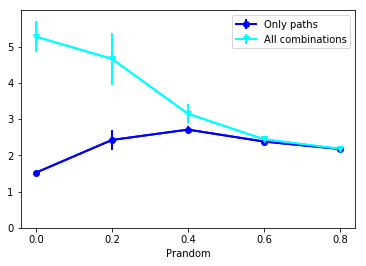

In [25]:
pathAllMean = np.zeros((len(pR),1))
pathAllStd = np.zeros((len(pR),1))

pathOnlyPathsMean = np.zeros((len(pR),1))
pathOnlyPathsStd = np.zeros((len(pR),1))

percNoPathMean = np.zeros((len(pR),1))
percNoPathStd = np.zeros((len(pR),1))


for ind,p in enumerate(pR):
    
    pathAllMean[ind] = np.mean(pathAll[ind,:])    
    pathAllStd[ind] = np.std(pathAll[ind,:])
    
    pathOnlyPathsMean[ind] = np.mean(pathOnlyPaths[ind,:])    
    pathOnlyPathsStd[ind] = np.std(pathOnlyPaths[ind,:])    
    
    percNoPathMean[ind] = np.mean(percNoPath[ind,:])
    percNoPathStd[ind] = np.mean(percNoPath[ind,:])
    
    

plt.plot(pR,pathOnlyPathsMean,color='blue',linewidth=2)
plt.plot(pR,pathAllMean,color='cyan',linewidth=2)


plt.errorbar(pR,pathOnlyPathsMean,pathOnlyPathsStd,marker= 'o',color='blue',linewidth=2,label='Only paths')
plt.errorbar(pR,pathAllMean,pathAllStd,marker= 'v',color='cyan',linewidth=2,label='All combinations')

plt.legend()
plt.xticks(pR)

plt.yticks([0,1,2,3,4,5])
plt.ylim([0,6])      

plt.xlabel('Prandom')
plt.ylabel('Path length')

Text(0,0.5,'Percentage of pairs with no path')

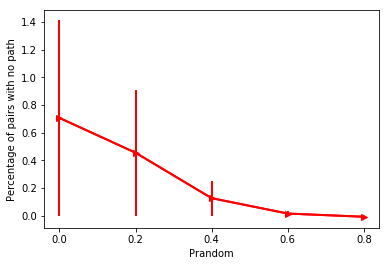

In [27]:
plt.plot(pR,percNoPathMean,color='red',linewidth=2)

plt.errorbar(pR,percNoPathMean,percNoPathStd,marker= '>',color='red',linewidth=2,label='% no path')

plt.xticks(pR)

plt.xlabel('Prandom')
plt.ylabel('Percentage of pairs with no path')